In [1]:
from lbg_forecast.likelihood import pack_params
from lbg_forecast.likelihood import unpack_params
from lbg_forecast.likelihood import get_cosmo_params
from lbg_forecast.likelihood import Likelihood
import lbg_forecast.utils as utils

from lbg_forecast.angular_power import define_cosmo
from lbg_forecast.angular_power import pk
import lbg_forecast.angular_power as ap

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax_cosmo as jc

In [2]:
def trig_plot(nparams, params, F, F_marg, labels):
    
    plt.figure(figsize=(25, 25))

    #randnos = np.random.multivariate_normal(np.array([params[0], params[1]]),
    #                                         np.linalg.inv(F), 1000)
    for i in range(nparams):
        for j in range(nparams):
            if j<i:
                plt.subplot(nparams,nparams,i*nparams+j+1)
                plt.subplots_adjust(wspace=0, hspace=0)


                plt.grid(alpha=0.4, zorder=-1)

                utils.plot_contours(F, params, j, i, K=2.279, fill=True,color='k', alpha=0.3, zorder=5, ls="--", lw=2)
                utils.plot_contours(F, params, j, i, K=5.991, fill=True,color='k',  alpha=0.3, zorder=5, ls="--", lw=2)
                #plot_contours(F, params, j, i, K=9.210, fill=True,color='k',  alpha=0.3, zorder=5, ls="--", lw=2)
                    #plot_contours(F, params, j, i, K=11.618, fill=True,color='b',  alpha=0.3, zorder=5)

                utils.plot_contours(F_marg, params, j, i, K=2.279, fill=True,color='r', alpha=0.3, zorder=1, lw=2)
                utils.plot_contours(F_marg, params, j, i, K=5.991, fill=True,color='r', alpha=0.3, zorder=1, lw=2)
                    #plot_contours(F_marg, params, j, i, K=9.210, fill=True,color='r',  alpha=0.3, zorder=1)
                    #plot_contours(F_marg, params, j, i, K=11.618, fill=True,color='r', alpha=0.3, zorder=1)
                

                if(j == 0):
                    plt.ylabel(labels[i], fontsize = 32)

                if(i == nparams-1):
                    plt.xlabel(labels[j], fontsize = 32)

                plt.tick_params(axis="x", width = 2, labelsize=15)
                plt.tick_params(axis="y", width = 2, labelsize=15)

                if(i < nparams - 1):
                    plt.tick_params(
                        axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        labelbottom=False)
                    
                if(j > 0):
                    plt.tick_params(
                        axis='y',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        left=False,        # ticks along the bottom edge are off
                        labelleft=False)
                #plt.scatter(randnos[:,0], randnos[:, 1], c ='r', zorder=100, alpha=.5, s=10)

In [3]:
path = "./"
lhood = Likelihood(path)

Initialising likelihood
Initialisation Complete


In [4]:
def forecast_derived():
    o_m = lhood._cosmo_fid.Omega_c + lhood._cosmo_fid.Omega_b
    s8 = lhood._cosmo_fid.sigma8*np.sqrt(o_m/0.3)

    params = np.array([o_m, s8, lhood._cosmo_fid.Omega_b,
                    lhood._cosmo_fid.h, lhood._cosmo_fid.n_s,
                    lhood._b_lbg_u, lhood._b_lbg_g, lhood._b_lbg_r])

    labels = np.array(["$\Omega_{m}$", "$S_{8}$","$\Omega_{b}$",
                        "$h$", "$n_{s}$", "$b^{lbg}_{u}$", "$b^{lbg}_{g}$", "$b^{lbg}_{r}$"])

    F = lhood.fisher_deriv(params)
    F_marg = lhood.fisher_marg_deriv(params)

    return F, F_marg, params, labels


In [5]:
def forecast():

    params = np.array([lhood._cosmo_fid.sigma8, 
                    lhood._cosmo_fid.Omega_c, lhood._cosmo_fid.Omega_b,
                    lhood._cosmo_fid.h, lhood._cosmo_fid.n_s,
                    lhood._b_lbg_u, lhood._b_lbg_g, lhood._b_lbg_r])

    labels = np.array(["$\sigma_{8}$", "$\Omega_{c}$", "$\Omega_{b}$",
                        "$h$", "$n_{s}$", "$b^{lbg}_{u}$", "$b^{lbg}_{g}$", "$b^{lbg}_{r}$"])

    F = lhood.fisher(params)
    F_marg = lhood.fisher_marg(params)

    return F, F_marg, params, labels

In [6]:
F, F_marg, params, labels = forecast()

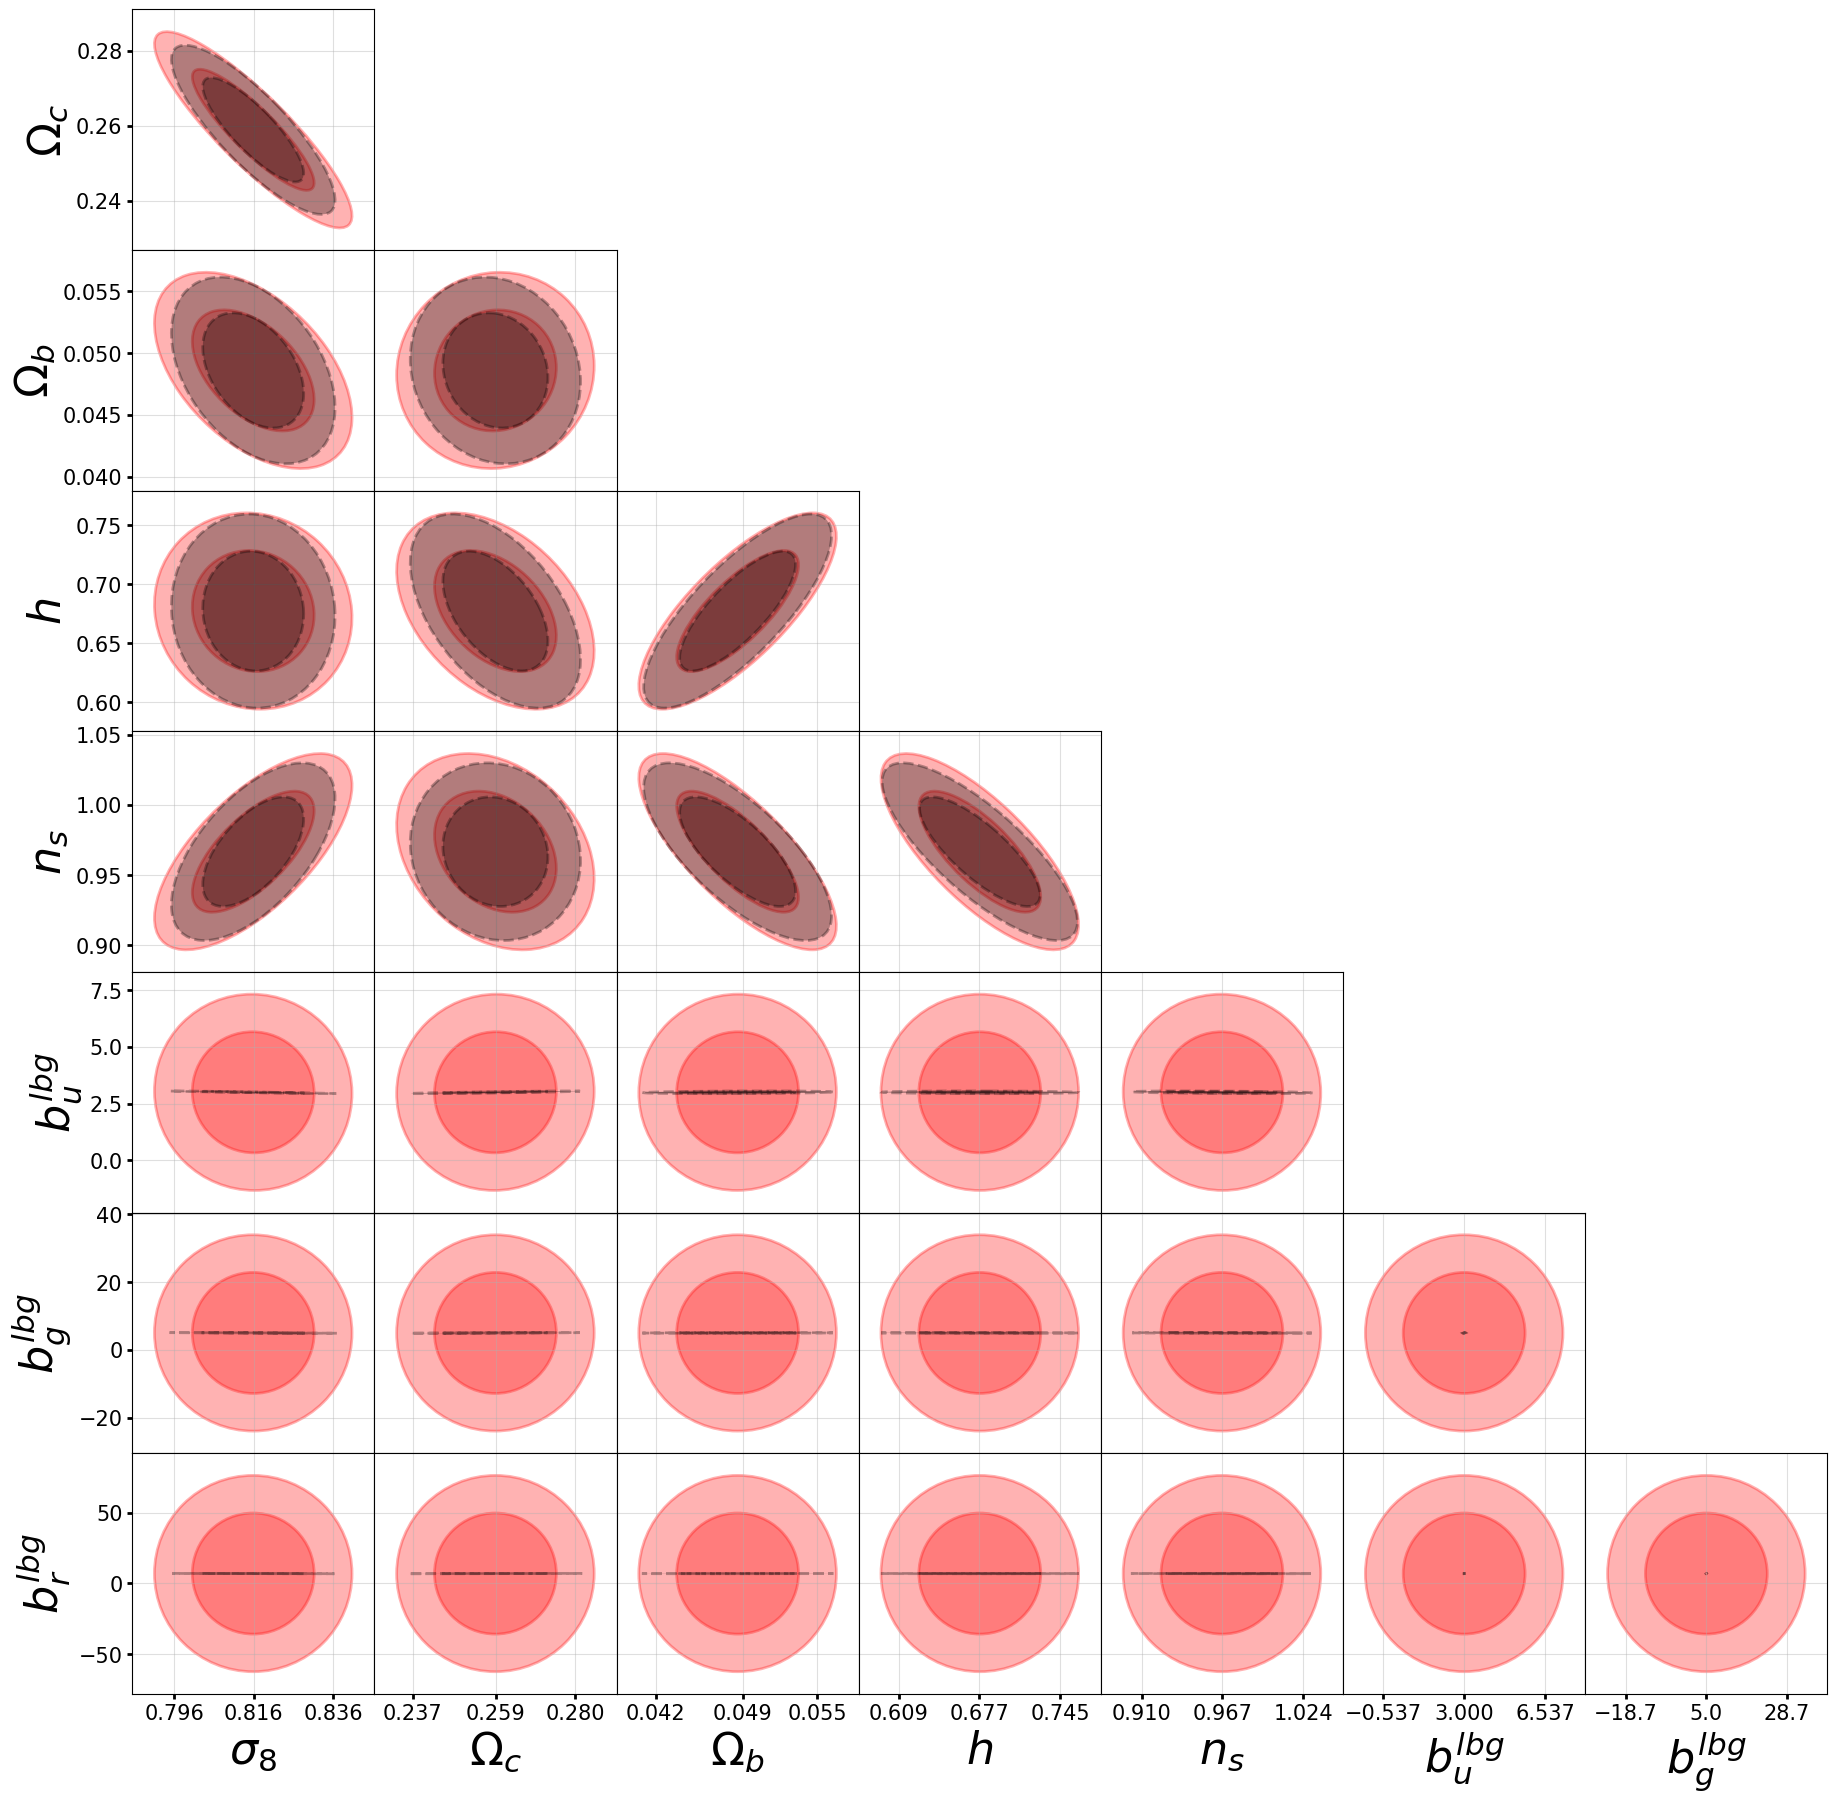

In [7]:
trig_plot(len(params), params, F, F_marg, labels)

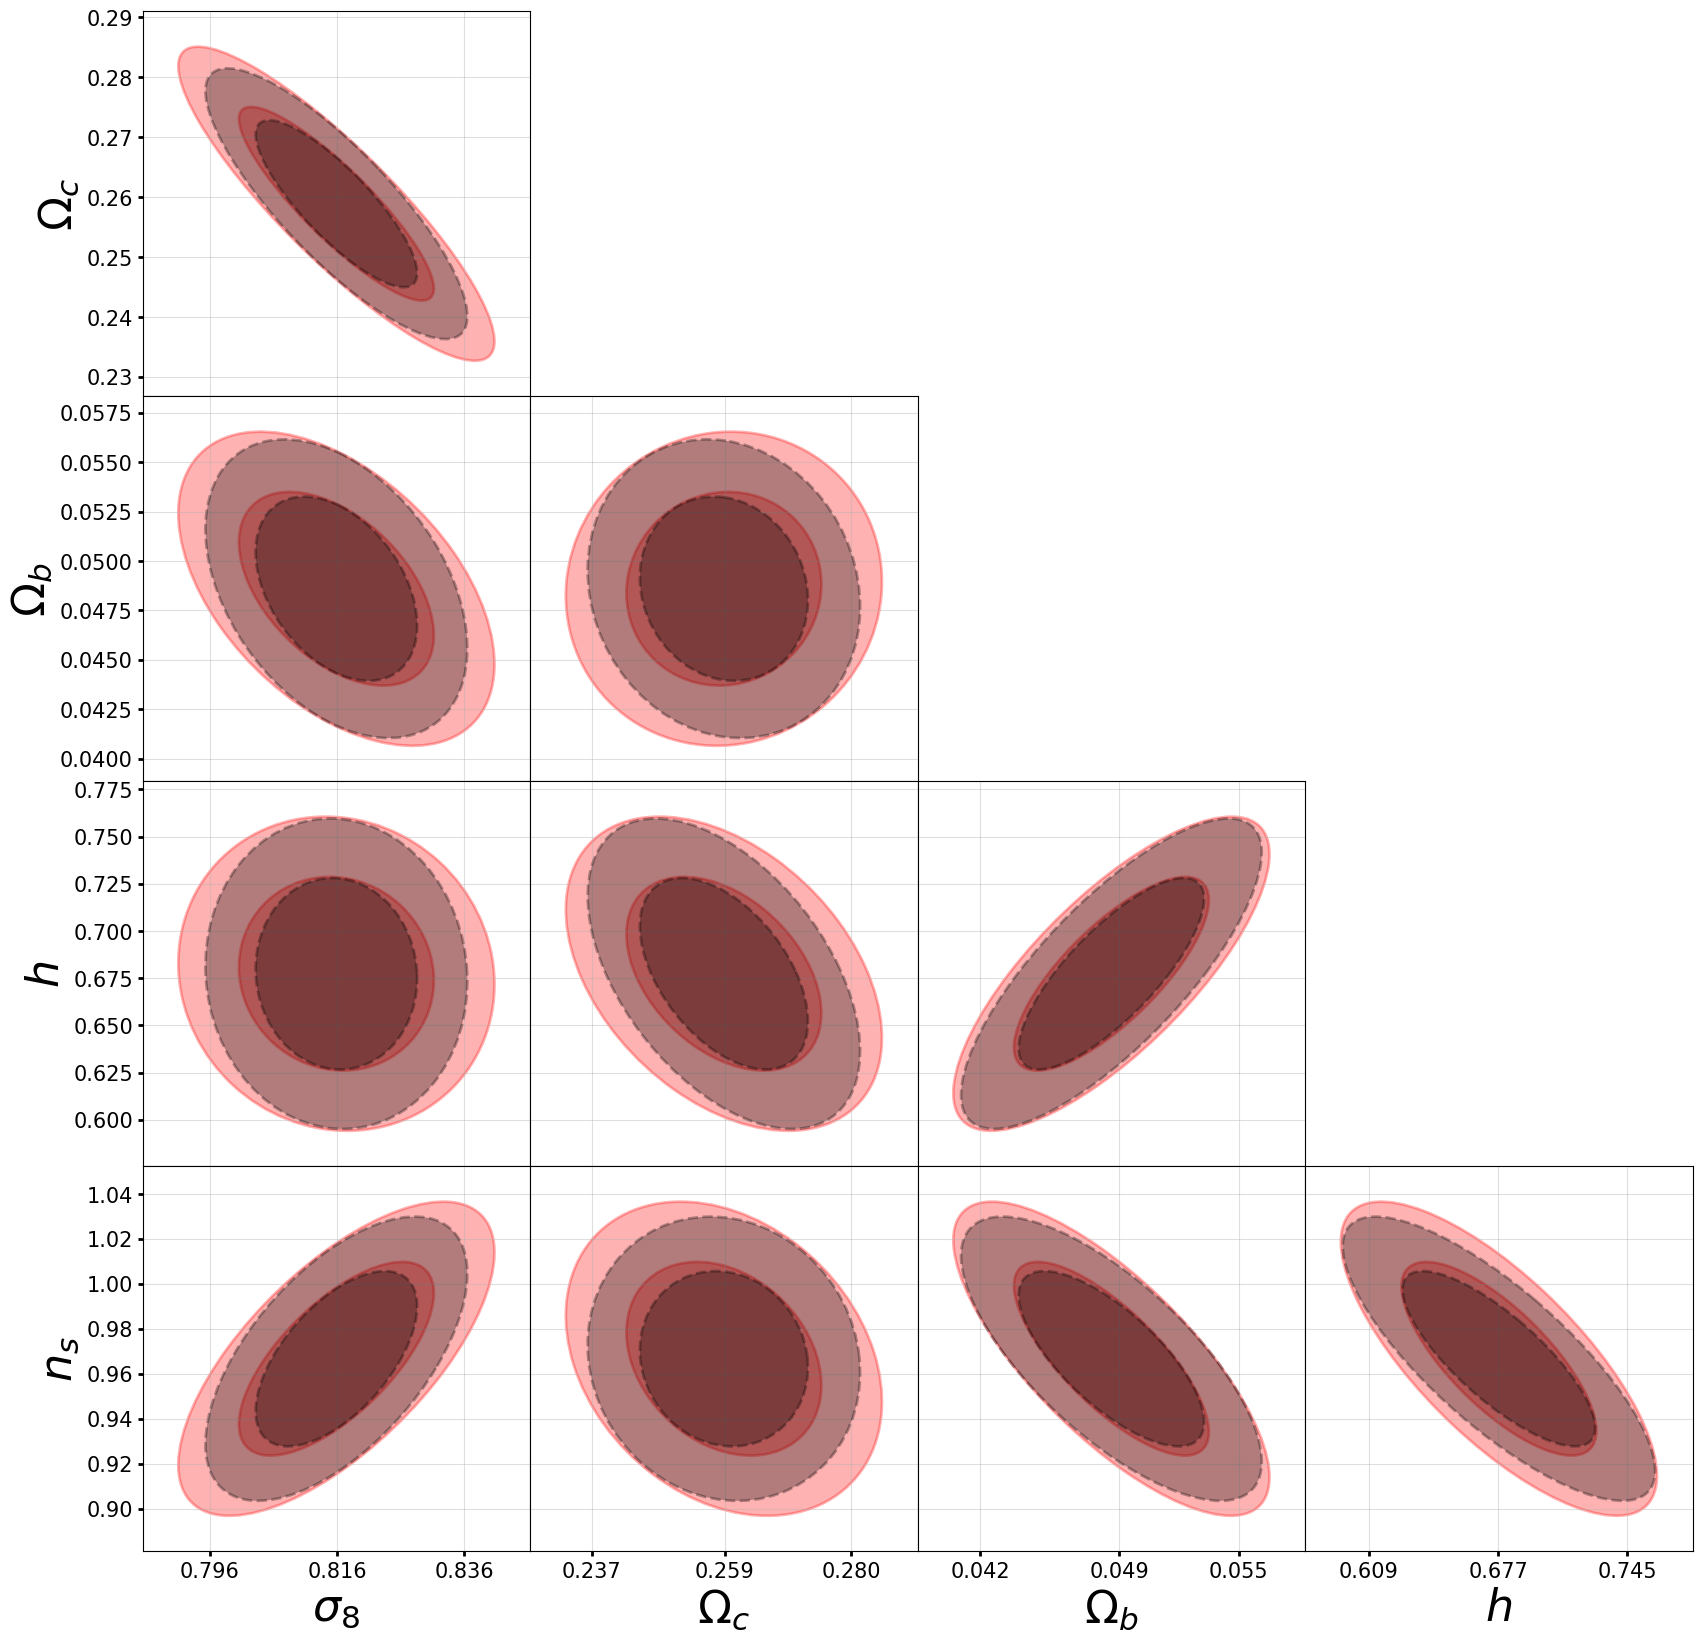

In [8]:
trig_plot(5, params, F, F_marg, labels)

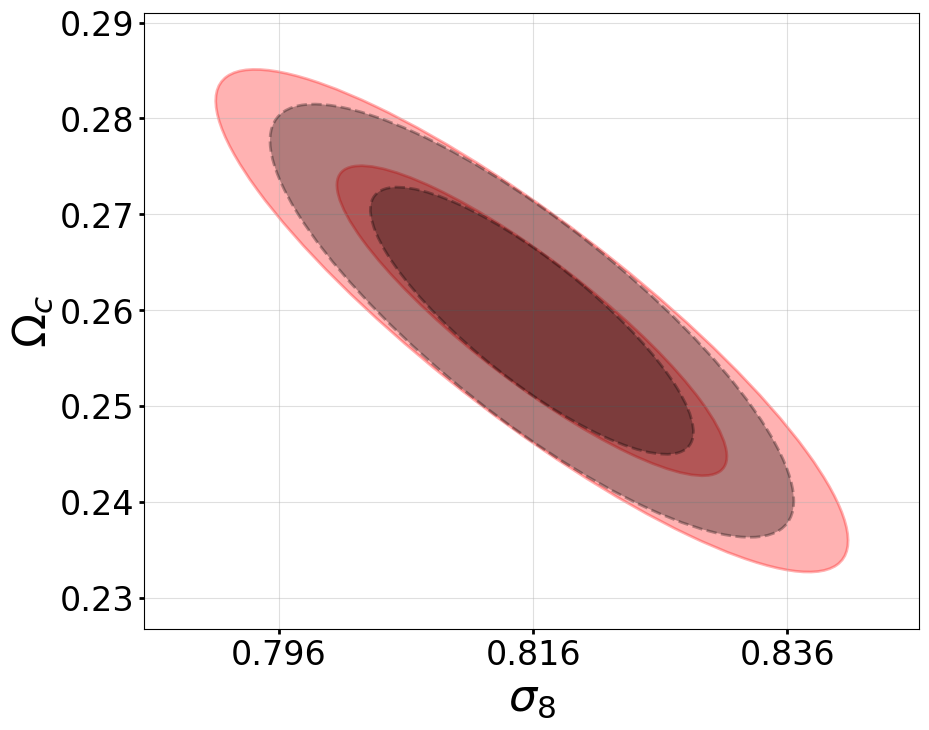

In [9]:
i = 1
j = 0
plt.figure(figsize=(10, 8))
plt.grid(alpha=0.4, zorder=-1)

utils.plot_contours(F, params, j, i, K=2.279, fill=True,color='k', alpha=0.3, zorder=5, ls="--", lw=2)
utils.plot_contours(F, params, j, i, K=5.991, fill=True,color='k',  alpha=0.3, zorder=5, ls="--", lw=2)

utils.plot_contours(F_marg, params, j, i, K=2.279, fill=True,color='r', alpha=0.3, zorder=1, lw=2)
utils.plot_contours(F_marg, params, j, i, K=5.991, fill=True,color='r', alpha=0.3, zorder=1, lw=2)

plt.ylabel(labels[i], fontsize = 32)
plt.xlabel(labels[j], fontsize = 32)

plt.tick_params(axis="x", width = 2, labelsize=24)
plt.tick_params(axis="y", width = 2, labelsize=24)


In [10]:
F, F_marg, params, labels = forecast_derived()

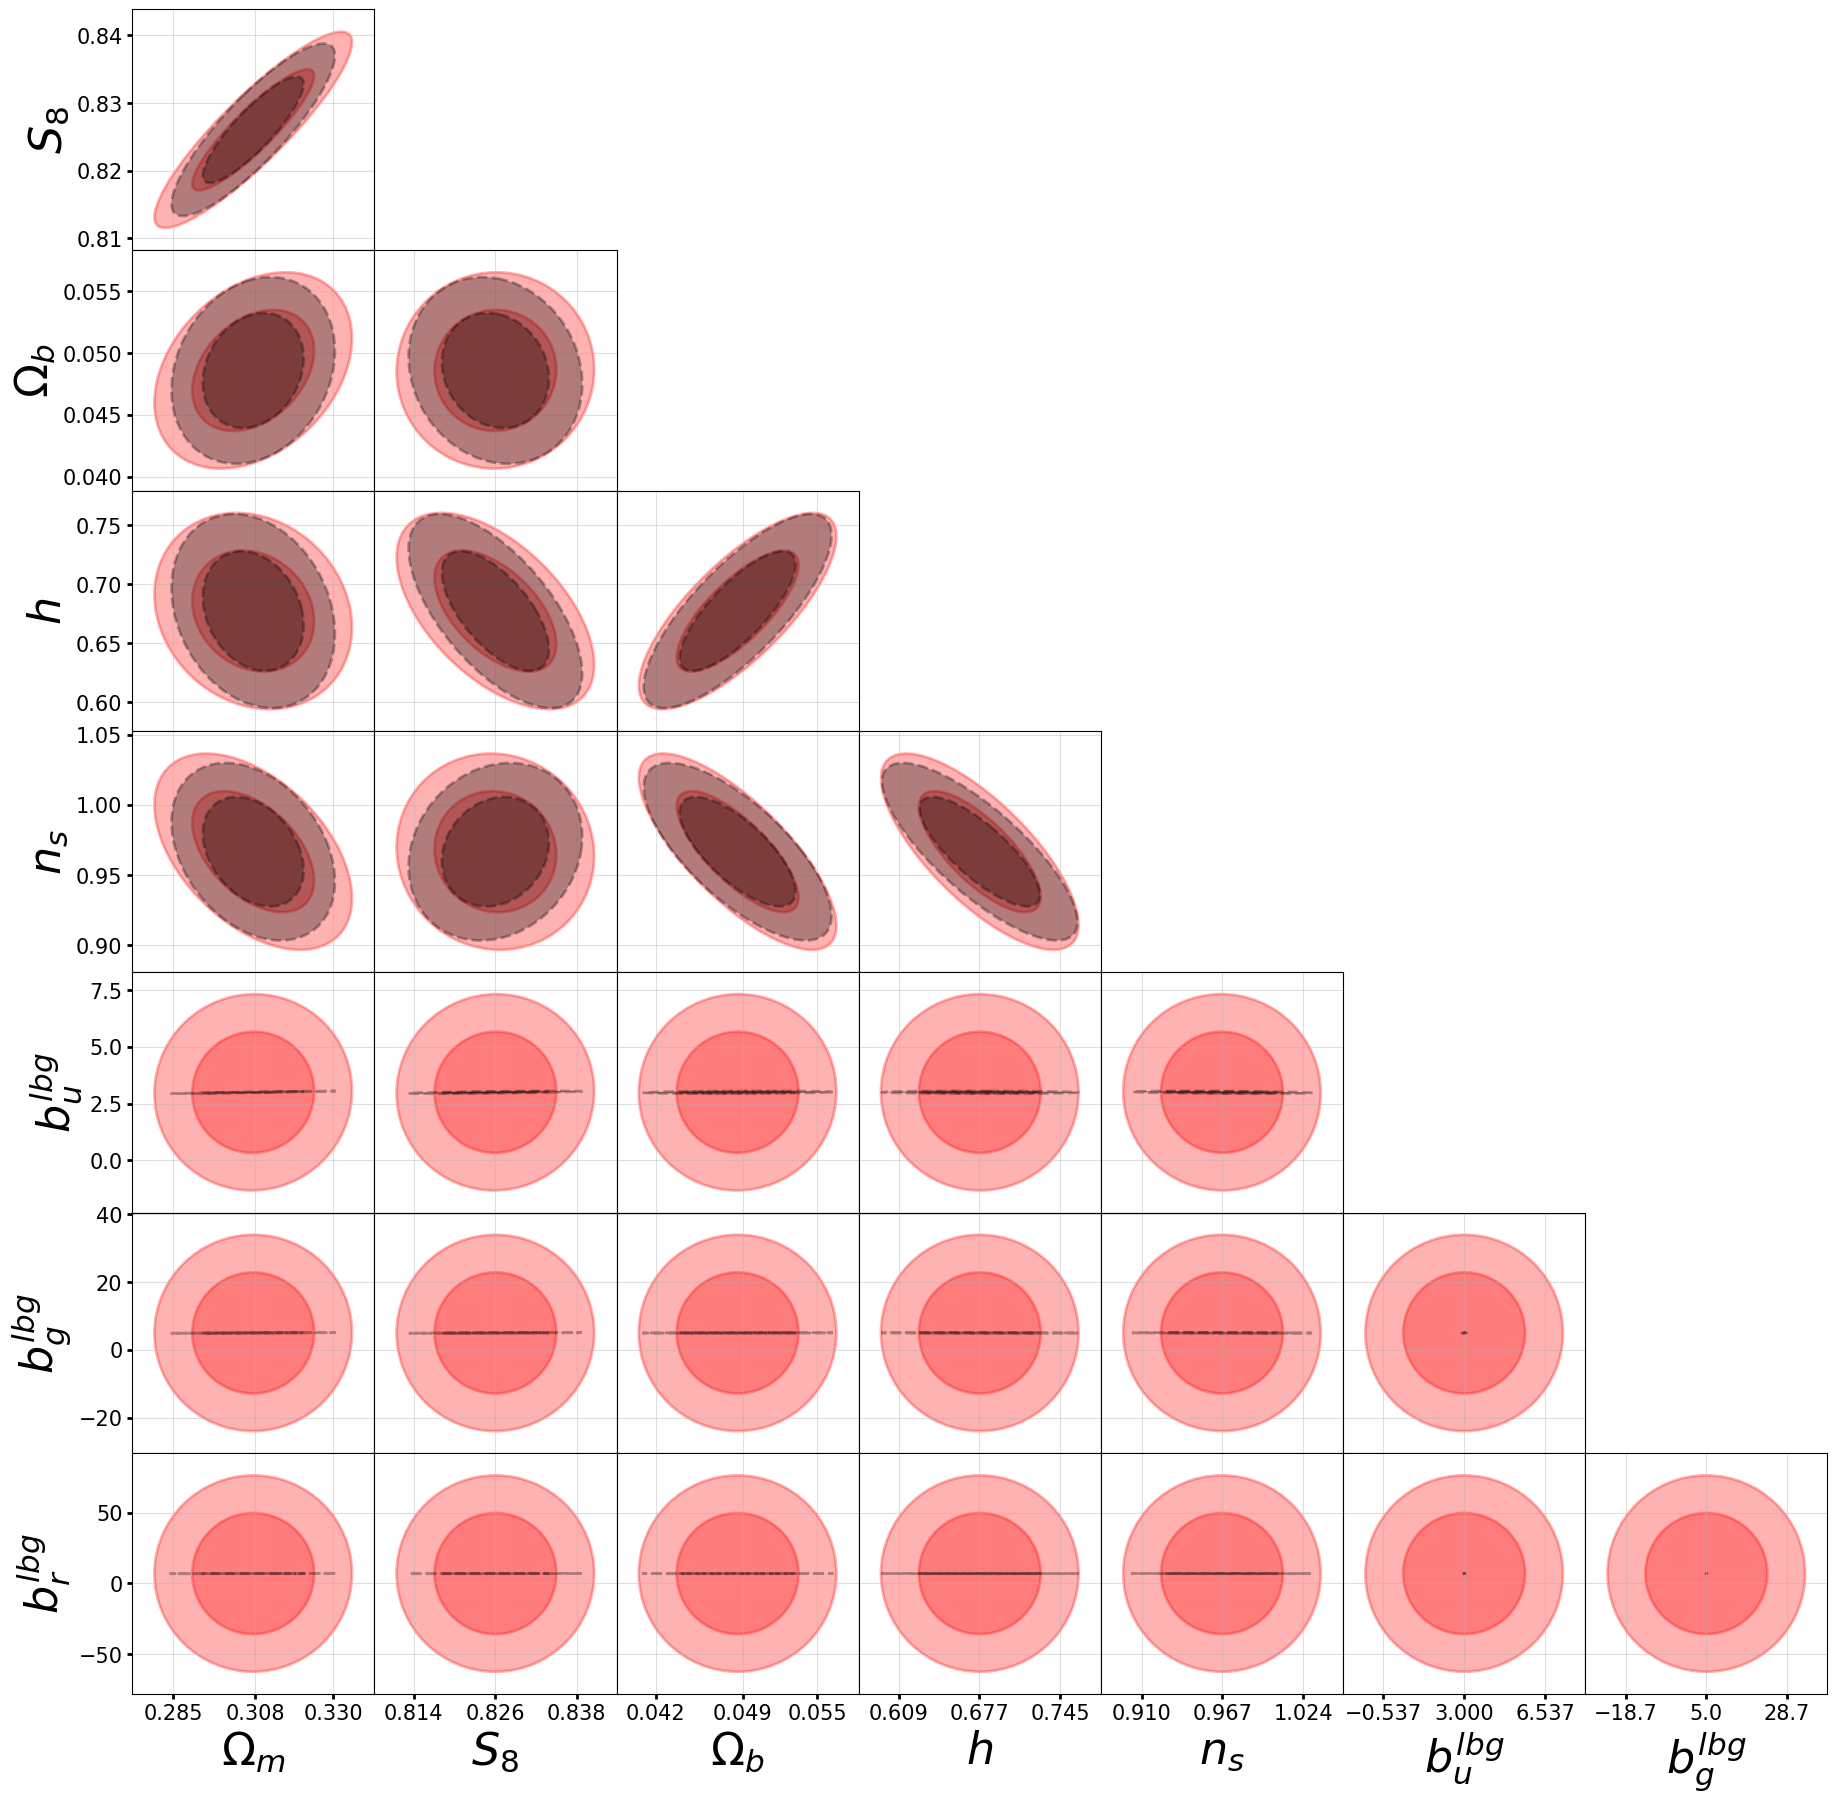

In [11]:
trig_plot(len(params), params, F, F_marg, labels)

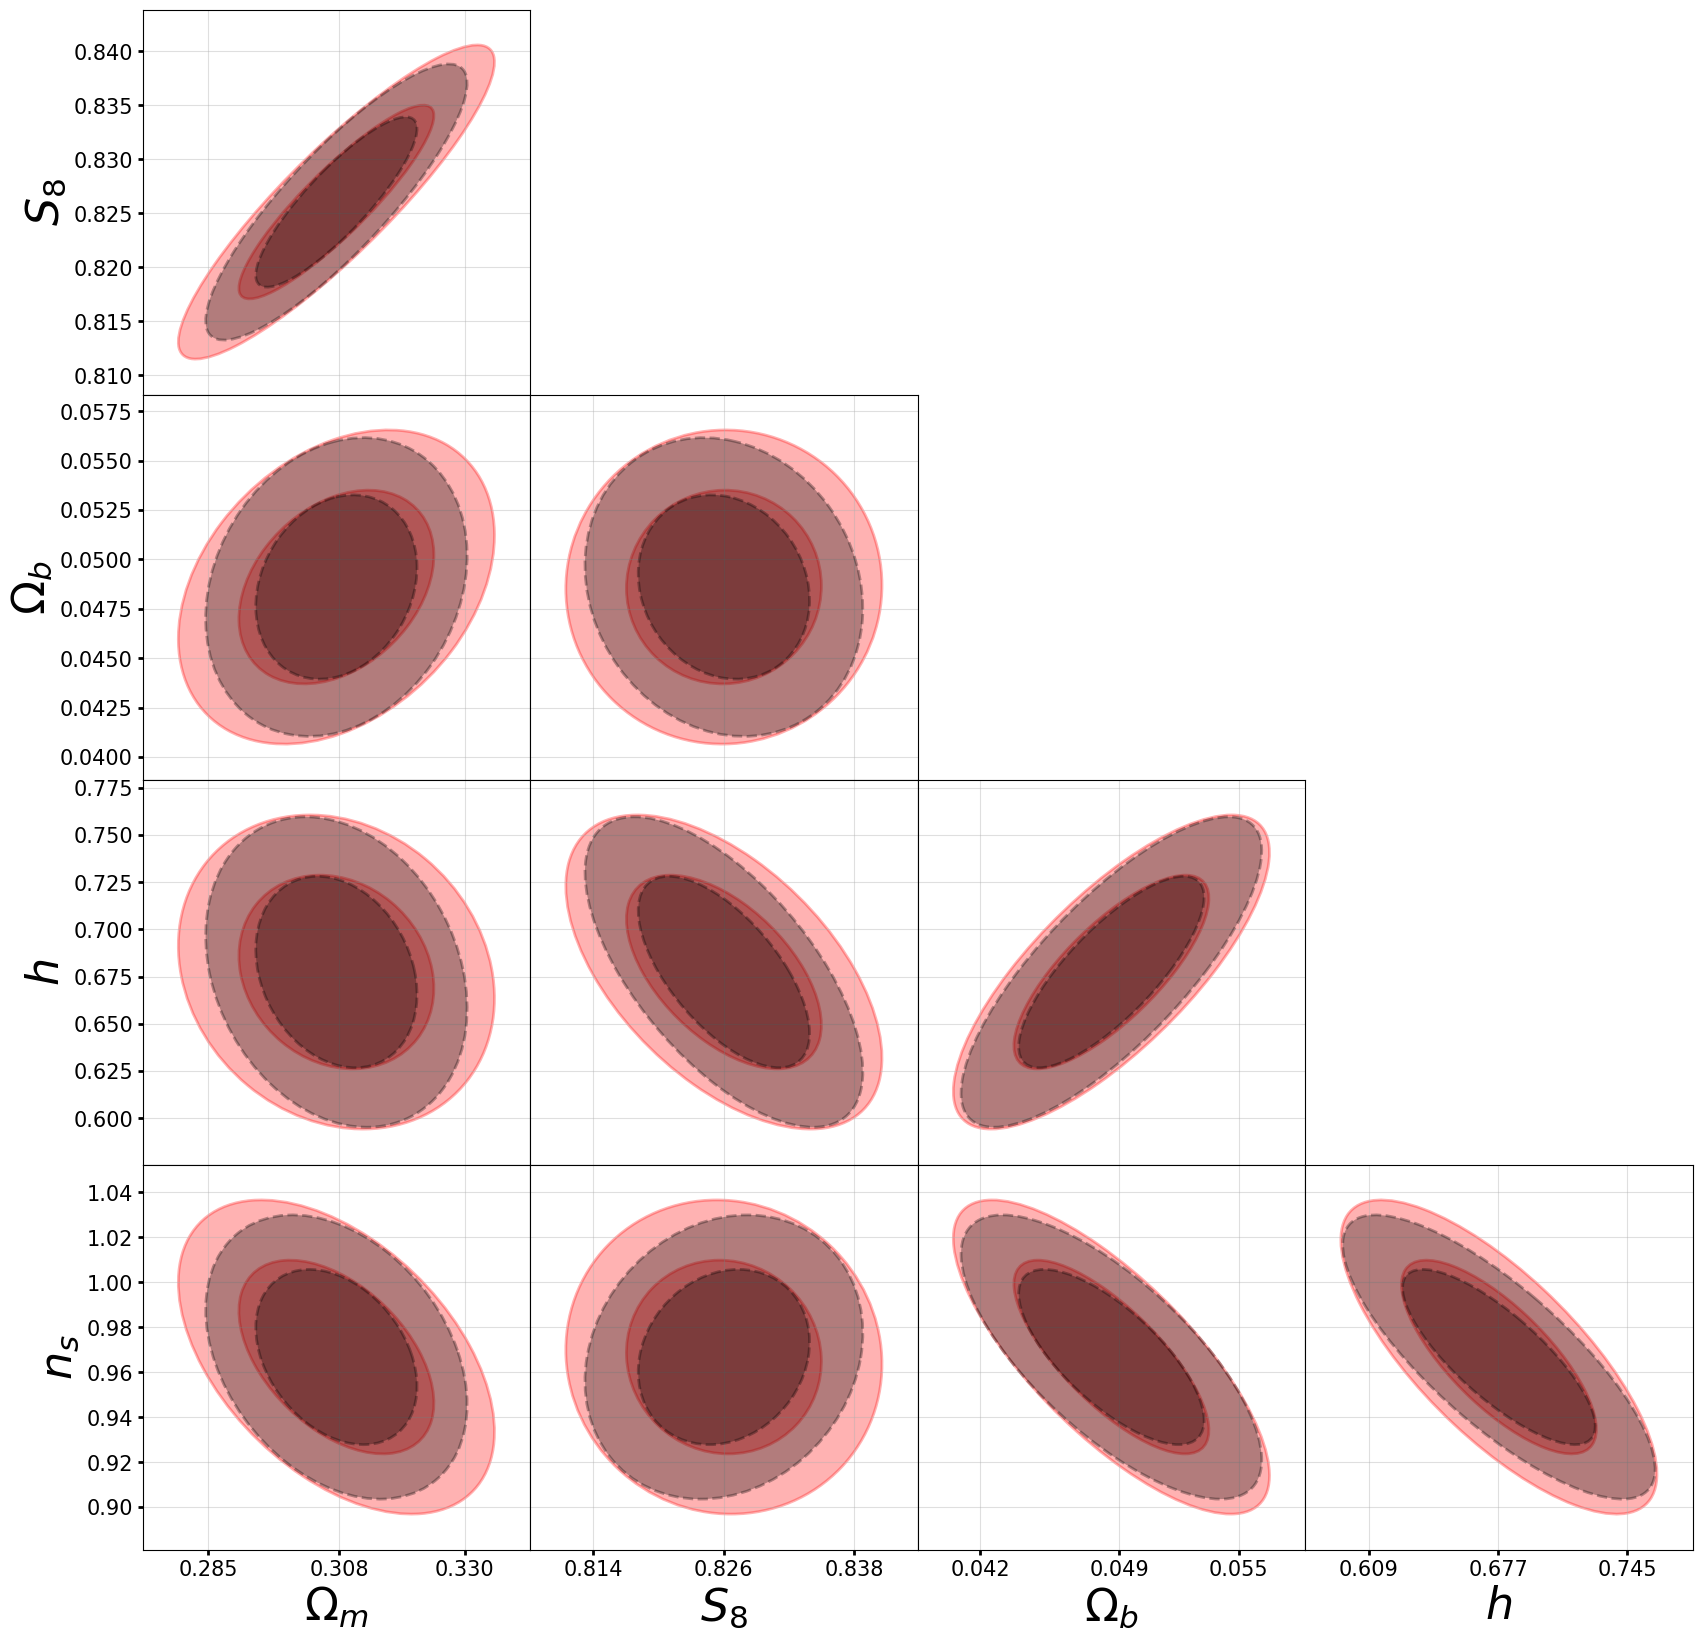

In [12]:
trig_plot(5, params, F, F_marg, labels)

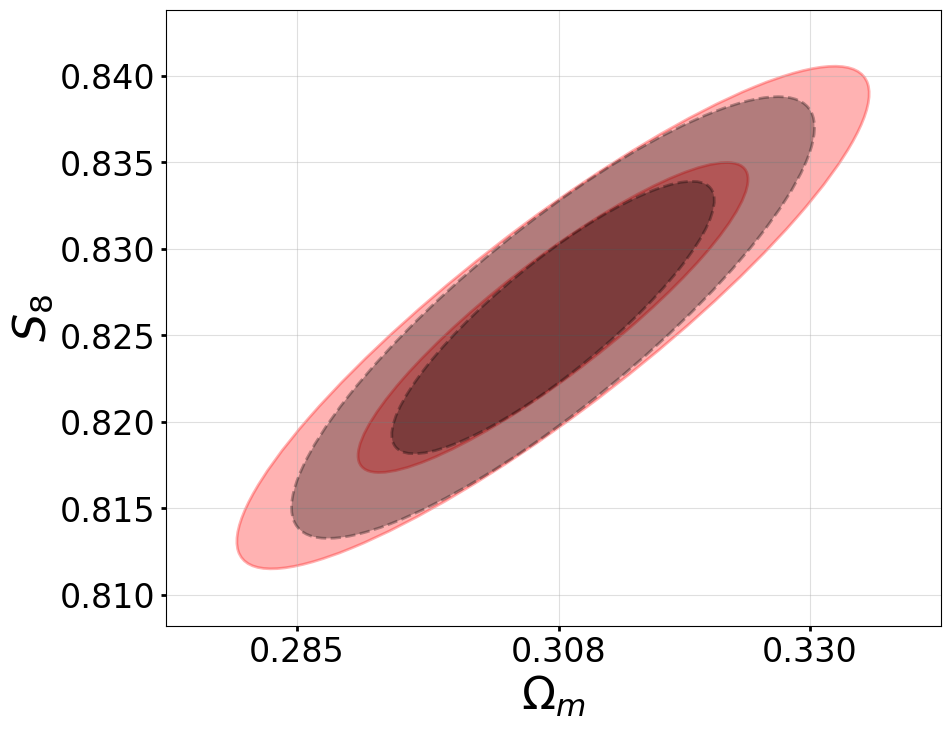

In [13]:
i = 1
j = 0
plt.figure(figsize=(10, 8))
plt.grid(alpha=0.4, zorder=-1)

utils.plot_contours(F, params, j, i, K=2.279, fill=True,color='k', alpha=0.3, zorder=5, ls="--", lw=2)
utils.plot_contours(F, params, j, i, K=5.991, fill=True,color='k',  alpha=0.3, zorder=5, ls="--", lw=2)

utils.plot_contours(F_marg, params, j, i, K=2.279, fill=True,color='r', alpha=0.3, zorder=1, lw=2)
utils.plot_contours(F_marg, params, j, i, K=5.991, fill=True,color='r', alpha=0.3, zorder=1, lw=2)

plt.ylabel(labels[i], fontsize = 32)
plt.xlabel(labels[j], fontsize = 32)

plt.tick_params(axis="x", width = 2, labelsize=24)
plt.tick_params(axis="y", width = 2, labelsize=24)